<a href="https://colab.research.google.com/github/Ray-off/IMDB_RNN1.ipynb/blob/main/Flamingam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download aasheesh200/framingham-heart-study-dataset

Dataset URL: https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset
License(s): unknown
  0% 0.00/58.0k [00:00<?, ?B/s]
100% 58.0k/58.0k [00:00<00:00, 141MB/s]


In [3]:
!unzip framingham-heart-study-dataset.zip

Archive:  framingham-heart-study-dataset.zip
  inflating: framingham.csv          


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
df = pd.read_csv('framingham.csv')

In [38]:
df.shape

(4240, 16)

In [39]:
df.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [40]:
print(df.isnull().sum())

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [41]:
df = df.dropna()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3658 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3658 non-null   int64  
 1   age              3658 non-null   int64  
 2   education        3658 non-null   float64
 3   currentSmoker    3658 non-null   int64  
 4   cigsPerDay       3658 non-null   float64
 5   BPMeds           3658 non-null   float64
 6   prevalentStroke  3658 non-null   int64  
 7   prevalentHyp     3658 non-null   int64  
 8   diabetes         3658 non-null   int64  
 9   totChol          3658 non-null   float64
 10  sysBP            3658 non-null   float64
 11  diaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  heartRate        3658 non-null   float64
 14  glucose          3658 non-null   float64
 15  TenYearCHD       3658 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 485.8 KB


In [43]:
print(df.isnull().sum())

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3658 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3658 non-null   int64  
 1   age              3658 non-null   int64  
 2   education        3658 non-null   float64
 3   currentSmoker    3658 non-null   int64  
 4   cigsPerDay       3658 non-null   float64
 5   BPMeds           3658 non-null   float64
 6   prevalentStroke  3658 non-null   int64  
 7   prevalentHyp     3658 non-null   int64  
 8   diabetes         3658 non-null   int64  
 9   totChol          3658 non-null   float64
 10  sysBP            3658 non-null   float64
 11  diaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  heartRate        3658 non-null   float64
 14  glucose          3658 non-null   float64
 15  TenYearCHD       3658 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 485.8 KB


In [45]:
X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"]

In [46]:
df.shape

(3658, 16)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [50]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

n_features = X_train.shape[1]

model = Sequential([
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(n_features,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,617 (29.75 KB)

 Non-trainable params: 320 (1.25 KB)

In [52]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [53]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping],
    verbose=1
)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4996 - loss: 1.0657 - val_accuracy: 0.7679 - val_loss: 0.6386
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6366 - loss: 0.7434 - val_accuracy: 0.8003 - val_loss: 0.5485
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7048 - loss: 0.6013 - val_accuracy: 0.8106 - val_loss: 0.4983
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7597 - loss: 0.5816 - val_accuracy: 0.8140 - val_loss: 0.4674
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7842 - loss: 0.5246 - val_accuracy: 0.8157 - val_loss: 0.4527
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7992 - loss: 0.4885 - val_accuracy: 0.8157 - val_loss: 0.4458
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8184 - loss: 0.4822 - val_accuracy: 0.8208 - val_loss: 0.4406
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8263 - loss: 0.4689 - val_accuracy: 0.8242 -

In [21]:
X_train.shape

(2926, 15)

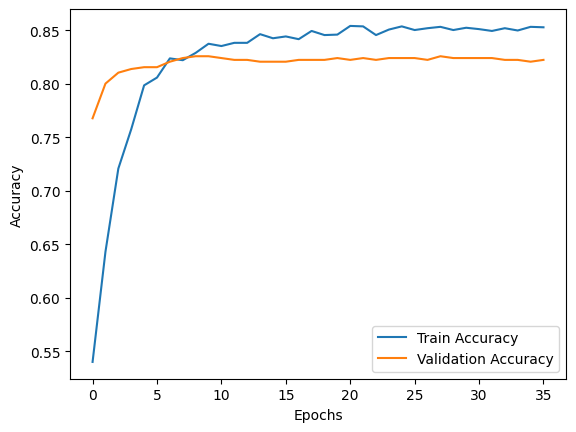

In [54]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [57]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Test Accuracy :{accuracy*100:.2f}%")

Test Accuracy :84.97%


In [58]:
# Example: 55-year-old female, smoker, etc.
new_data = pd.DataFrame([[
    0,      # male: 0=female
    55,     # age
    2,      # education
    1,      # currentSmoker
    15,     # cigsPerDay
    0,      # BPMeds
    0,      # prevalentStroke
    1,      # prevalentHyp
    0,      # diabetes
    250,    # totChol
    140,    # sysBP
    90,     # diaBP
    28.5,   # BMI
    80,     # heartRate
    95      # glucose
]], columns=['male','age','education','currentSmoker','cigsPerDay',
             'BPMeds','prevalentStroke','prevalentHyp','diabetes',
             'totChol','sysBP','diaBP','BMI','heartRate','glucose'])


In [59]:
new_data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,55,2,1,15,0,0,1,0,250,140,90,28.5,80,95


In [60]:
scaled_data = scaler.transform(new_data)


In [61]:
prob = model.predict(scaled_data)[0][0]  # probability of CVD
print(f"Predicted probability of CVD in 10 years: {prob:.2%}")


if prob >= 0.5:
    print("High Risk: In danger zone")
else:
    print("Low Risk: Not in danger zone")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted probability of CVD in 10 years: 15.84%
Low Risk: Not in danger zone
